# Calculate Background

## Imports

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
from astropy.table import Table
from scipy.interpolate import interp1d
from scipy.integrate import trapezoid
import json
import os

## Backgrounds

Sky emission curves in optical and infrared wavelength ranges are saved in `../Data/backgrounds/`

`highski.dat`: optical sky background taken from [HST](https://hst-docs.stsci.edu/acsihb/chapter-9-exposure-time-calculations/9-7-tabular-sky-backgrounds), in $\rm erg/s/cm^2/angstrom/arcsec^2$ - $\rm angstrom$;

`background_earth.txt`: sky background from 0.5 to 30 micron at earth orbit from [here](https://irsa.ipac.caltech.edu/applications/BackgroundModel/), in $\rm MJy/sr$ - $\rm micron$;  

`background_l2.txt`: sky background from 0.5 to 30 micron at L2 point from [here](https://irsa.ipac.caltech.edu/applications/BackgroundModel/), in $\rm MJy/sr$ - $\rm micron$;  

`jwstbg.txt`: sky background from 0.5 to 30 mircon specifically for JWST obtained by [jwst_backgrounds](https://github.com/spacetelescope/jwst_backgrounds), in in $\rm MJy/sr$ - $\rm micron$.  

In [ ]:
data_path = '../Data'
bkg_path = os.path.join(data_path, 'backgrounds')

In [2]:
highsky = np.loadtxt(bkg_path + '/highsky.dat')
background_earth = Table.read(bkg_path + '/background_earth.txt',
                              format='ipac', 
                              include_names=['wavelength', 'totbg', 'obsloc'])
background_l2 = Table.read(bkg_path + '/background_l2.txt',
                              format='ipac', 
                              include_names=['wavelength', 'totbg', 'obsloc'])
jwstbg = np.loadtxt(bkg_path + '/jwstbg.txt')

## Conversion

From $\rm erg/s/cm^2/angstrom/arcsec^2$ to $\rm MJy/sr$: 
$$
f_\nu = \frac{\lambda^2}{c}f_\lambda
$$

In [3]:
highsky_in_MJy_sr = (highsky[:, 1] * (u.erg/u.s/u.cm**2/u.angstrom/u.arcsec**2)\
                    * (highsky[:, 0] * u.angstrom)**2 / const.c).to(u.MJy/u.sr).value

## Standardize

In [4]:
# in AA - MJy/sr
background_optical = np.column_stack((highsky[:, 0], highsky_in_MJy_sr))
background_earth = np.column_stack((background_earth['wavelength'] * 10**4, background_earth['totbg']))
background_l2 = np.column_stack((background_l2['wavelength'] * 10**4, background_l2['totbg']))
background_jwst = np.column_stack((jwstbg[:, 0] * 10**4, jwstbg[:, 1]))

Text(0, 0.5, 'Flux [MJy/sr]')

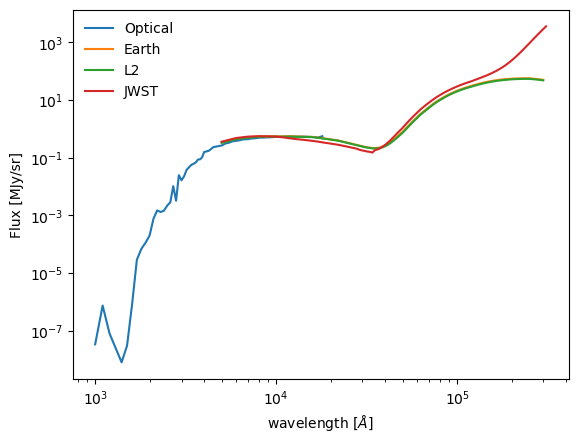

In [5]:
plt.plot(background_optical[:, 0], background_optical[:, 1], label='Optical')
plt.plot(background_earth[:, 0], background_earth[:, 1], label='Earth')
plt.plot(background_l2[:, 0], background_l2[:, 1], label='L2')
plt.plot(background_jwst[:, 0], background_jwst[:, 1], label='JWST')
plt.yscale('log')
plt.xscale('log')
plt.legend(frameon=False)
plt.xlabel(r'wavelength [$\AA$]')
plt.ylabel('Flux [MJy/sr]')

## Sky background calculation

$$
B_{\rm sky} = A_{\rm eff}\int I_{\rm sky}l_p^2\tau(\lambda)\frac{\lambda}{hc}d\lambda
$$  
where $A_{\rm eff}$, $I_{\rm sky}$, $l_p$ and $\tau(\lambda)$ are effective area, sky emission intensity, pixelscale and throughput respectively. And $h$ and $c$ are Planck's constant and speed of light respectively.

In [6]:
def calc_bkg(bkg, throughput, aperture, pixelscale):
    I_sky = ((bkg[:, 1] * (u.MJy/u.sr) * const.c) \
        / (bkg[:, 0] * u.angstrom)**2).to(u.erg/u.s/u.cm**2/u.angstrom/u.arcsec**2)
    I_sky_interp = interp1d(bkg[:, 0], I_sky.value, kind='linear', bounds_error=False,
                            fill_value=0)
    throughput = throughput[throughput[:, 1] > 10**-4]
    I_sky_in_fil = I_sky_interp(throughput[:, 0]) * (u.erg/u.s/u.cm**2/u.angstrom/u.arcsec**2)
    wave = throughput[:, 0] * u.angstrom
    thr = throughput[:, 1]
    integral = trapezoid(wave * I_sky_in_fil * thr, wave)
    factor = np.pi * (aperture / 2 * u.m)**2 * (pixelscale * u.arcsec)**2 / (const.c * const.h)
    Bsky = factor * integral
    Bsky = Bsky.to(1 / u.s)
    Bsky = Bsky.value
    return Bsky

## Total background

$$
N_{\rm bkg} = \sqrt{(B_{\rm sky} + B_{\rm dark})t_{\rm exp}N_{\rm exp} + R_{\rm n}^2 N_{\rm exp}}
$$
where $B_{\rm sky}$, $B_{\rm dark}$, $t_{\rm exp}$, $N_{\rm exp}$, and $R_{\rm n}$ are the sky background calculated as before, dark current, exposure time, number of exposures, and readout noise, respectively.

In [22]:
def TotalBkg(survey, filters, info, Bkg, show_thr=False):
    
    if isinstance(filters, str):
        filters = [filters]
    
    Bdark = info['Bdark']
    Readout = info['Readout']
    ExpTime = info['ExpTime']
    pixelscale = info['pixelscale']
    aperture = info['aperture']

    if 'Nexp' in info.keys():
        Nexp = info['Nexp']
    else:
        Nexp = [1] * len(filters)

    Total_bkg = []
    for i, fil in enumerate(filters):
        thr = np.loadtxt(data_path + f'/filters/{survey}/{fil}.fil')
        if show_thr:
            plt.plot(thr[:, 0], thr[:, 1], label=fil)
        Bsky = calc_bkg(Bkg, thr, aperture, pixelscale)
        Total = np.sqrt((Bsky + Bdark) * ExpTime * Nexp[i] + Readout**2 * Nexp[i])
        print(f'{survey}.{fil}: {Total}')
        Total_bkg.append(Total)

    if show_thr:
        plt.legend(frameon=False)

    return Total_bkg


In [24]:
def save_bkg(survey, filters, TotalBkg):
    
    if isinstance(filters, str):
        filters = [filters]
    
    TotalBkg = [str(round(x, 2)) for x in TotalBkg]

    assert len(filters) == len(TotalBkg), "Number of filters and background values do not match."
    
    data = {f'{survey}':
        {
            f'{survey}_bands': ','.join(filters), 
            f'{survey}_Bkg': ','.join(TotalBkg)
        }
        }
    
    if os.path.exists(bkg_path + '/bkgNoise.json'):
        with open(bkg_path + '/bkgNoise.json', 'r') as f:
            bkg_data = json.load(f)
    else:
        bkg_data = {}

    bkg_data = bkg_data | data

    with open(bkg_path + '/bkgNoise.json', 'w') as f:
        json.dump(bkg_data, f, indent=4)
    

## CSST

CSST.NUV: 10.702802500988378
CSST.u: 8.094264055654154
CSST.g: 11.836383425775143
CSST.r: 12.796100802701957
CSST.i: 12.931626433283515
CSST.z: 11.002438144135667
CSST.y: 12.25838666275436


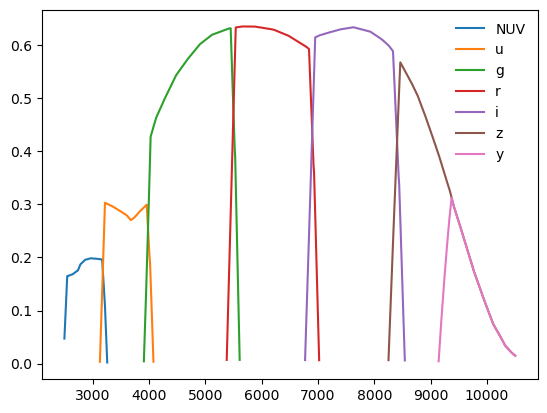

In [14]:
info = {}
info['Bdark'] = 0.02
info['Readout'] = 5
info['ExpTime'] = 150
info['aperture'] = 2.0
info['pixelscale'] = 0.074
info['Nexp'] = [4, 2, 2, 2, 2, 2, 4]

CSST_bands = ['NUV', 'u', 'g', 'r', 'i', 'z', 'y']

CSST_noise = TotalBkg('CSST', CSST_bands, info, background_optical, show_thr=True)

save_bkg('CSST', CSST_bands, CSST_noise)

## HST WFC3

Instrumental parameters of UVIS and IR of WFC3 can be found [here](https://www.stsci.edu/hst/instrumentation/wfc3/instrument-design/)

### UVIS

In [15]:
info = {}
info['Bdark'] = 3 / (60 * 60) # need investigation
info['Readout'] = 3.1
info['ExpTime'] = 600
info['aperture'] = 2.4
info['pixelscale'] = 0.04

HST_UV_bands = ['UV_F225W', 'UV_F275W', 'UV_F336W', 'UV_F390W', 'UV_F438W',
                'UV_F467M', 'UV_F555W', 'UV_F606W', 'UV_F775W', 'UV_F814W']

HST_UV_noise = TotalBkg('HST', HST_UV_bands, info, background_optical)

save_bkg('HST_UV', HST_UV_bands, HST_UV_noise)

HST.UV_F225W: 3.1883192901228234
HST.UV_F275W: 3.216747758905587
HST.UV_F336W: 3.526727075085606
HST.UV_F390W: 4.578883360366713
HST.UV_F438W: 4.5400049309284825
HST.UV_F467M: 3.8324119889369905
HST.UV_F555W: 7.109995257850256
HST.UV_F606W: 8.438900782155487
HST.UV_F775W: 6.0190529238245984
HST.UV_F814W: 6.62233395788925


### IR

In [16]:
info = {}
info['Bdark'] = 0.048
info['Readout'] = 21
info['ExpTime'] = 600
info['aperture'] = 2.4
info['pixelscale'] = 0.13

HST_IR_bands = ['IR_F105W', 'IR_F110W', 'IR_F125W', 'IR_F140W', 'IR_F160W']

HST_IR_noise = TotalBkg('HST', HST_IR_bands, info, background_earth)

save_bkg('HST_IR', HST_IR_bands, HST_IR_noise)

HST.IR_F105W: 40.418135945393296
HST.IR_F110W: 48.93148531475753
HST.IR_F125W: 39.91090132177506
HST.IR_F140W: 42.64836158417696
HST.IR_F160W: 36.01368091860915


## JWST

Instrumental parameters for JWST can be found [here](https://jwst-docs.stsci.edu/jwst-near-infrared-camera/nircam-instrumentation/nircam-detector-overview/nircam-detector-performance#gsc.tab=0) and [here](https://jwst-docs.stsci.edu/jwst-near-infrared-camera/nircam-instrumentation/nircam-detector-overview#gsc.tab=0)

### Long

In [17]:
info = {}
info['Bdark'] = 34.2 / 1000
info['Readout'] = 13.25
info['ExpTime'] = 600
info['aperture'] = 6.5
info['pixelscale'] = 0.063

JWST_long_bands = ['F250M', 'F277W', 'F300M', 'F322W2', 
             'F323N', 'F335M', 'F356W', 'F360M', 
             'F405N', 'F410M', 'F430M', 'F444W', 
             'F460M', 'F466N', 'F470N', 'F480M']

JWST_long_noise = TotalBkg('JWST', JWST_long_bands, info, background_jwst)

save_bkg('JWST_long', JWST_long_bands, JWST_long_noise)

JWST.F250M: 19.880169766292877
JWST.F277W: 29.261121491408026
JWST.F300M: 21.28903415746282
JWST.F322W2: 39.92309594305781
JWST.F323N: 14.642044597868153
JWST.F335M: 21.356776517153744
JWST.F356W: 29.975255442249132
JWST.F360M: 22.414135381828604
JWST.F405N: 15.39315713982232
JWST.F410M: 26.73550947060739
JWST.F430M: 22.880137622598987
JWST.F444W: 46.40776178188142
JWST.F460M: 25.418541677082597
JWST.F466N: 16.64159404757771
JWST.F470N: 16.55033075500047
JWST.F480M: 30.394323511764924


### Short

In [18]:
info = {}
info['Bdark'] = 1.9 / 1000
info['Readout'] = 15.77
info['ExpTime'] = 600
info['aperture'] = 6.5
info['pixelscale'] = 0.031

JWST_short_bands = ['F070W', 'F090W', 'F115W', 'F140M', 
              'F150W2', 'F150W', 'F162M', 'F164N', 
              'F182M', 'F187N', 'F200W', 'F210M', 
              'F212N', 'WLP4']

JWST_short_noise = TotalBkg('JWST', JWST_short_bands, info, background_jwst)

save_bkg('JWST_short', JWST_short_bands, JWST_short_noise)

JWST.F070W: 21.171555653720038
JWST.F090W: 22.783265576216095
JWST.F115W: 22.498971307645093
JWST.F140M: 19.495636725170975
JWST.F150W2: 34.988410398199065
JWST.F150W: 23.089431656739936
JWST.F162M: 19.43717776211599
JWST.F164N: 16.203452957132622
JWST.F182M: 19.998163448608025
JWST.F187N: 16.193096499425437
JWST.F200W: 22.569449890782337
JWST.F210M: 18.828158925961958
JWST.F212N: 16.15797352317371
JWST.WLP4: 16.593775816339708


## Roman

Instrumental parameters for Roman can be found in [here](https://roman.ipac.caltech.edu/sims/Param_db.html) and [here](https://roman-docs.stsci.edu/roman-instruments-home/wfi-imaging-mode-user-guide/introduction-to-wfi/wfi-quick-reference)

Roman.F062: 38.02613328399814
Roman.F087: 36.96348445242198
Roman.F106: 37.80639911800925
Roman.F129: 37.8960444080411
Roman.F158: 37.71127445683492
Roman.F184: 32.117767804449606
Roman.F213: 30.671337603336408
Roman.F146: 58.098919490851884


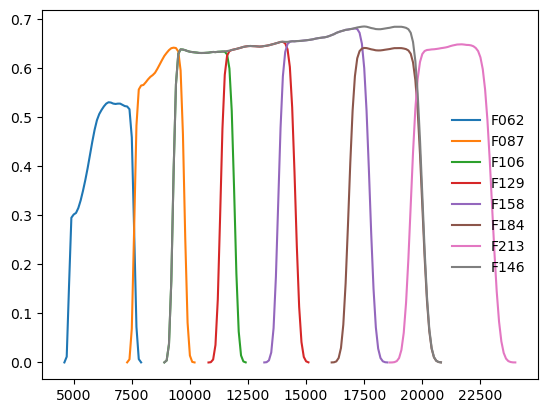

In [30]:
info = {}
info['Bdark'] = 0.1
info['Readout'] = 20
info['ExpTime'] = 600
info['aperture'] = 2.36
info['pixelscale'] = 0.11 

Roman_bands = ['F062', 'F087', 'F106', 'F129', 
               'F158', 'F184', 'F213', 'F146'] # need investigation

Roman_noise = TotalBkg('Roman', Roman_bands, info, background_l2, show_thr=True)

save_bkg('Roman', Roman_bands, Roman_noise)

## Euclid

Some instrumetal parameters for VIS and NISP can be found [here](https://sci.esa.int/web/euclid/-/euclid-vis-instrument) and [here](https://sci.esa.int/web/euclid/-/euclid-vis-instrument).  
And please refer to papers for [VIS](https://arxiv.org/abs/2405.13492) and [NISP](https://arxiv.org/abs/2405.13493) for more details.

### VIS

In [26]:
info = {}
info['Bdark'] = 0.005
info['Readout'] = 2.2
info['ExpTime'] = 600
info['aperture'] = 1.2
info['pixelscale'] = 0.1

Euclid_VIS_bands = 'VIS'

Euclid_VIS_noise = TotalBkg('Euclid', Euclid_VIS_bands, info, background_l2)
# Roman_noise = TotalBkg('Roman', Roman_bands, info, background_l2, show_thr=True)

save_bkg('Euclid_VIS', Euclid_VIS_bands, Euclid_VIS_noise)

Euclid.VIS: 20.91805665468285


### NISP

In [27]:
info = {}
info['Bdark'] = 0.02
info['Readout'] = 6
info['ExpTime'] = 600
info['aperture'] = 1.2
info['pixelscale'] = 0.3

Euclid_NISP_bands = ['Y', 'J', 'H']

Euclid_NISP_noise = TotalBkg('Euclid', Euclid_NISP_bands, info, background_l2)

save_bkg('Euclid_NISP', Euclid_NISP_bands, Euclid_NISP_noise)

Euclid.Y: 47.537237913506424
Euclid.J: 52.166437609440116
Euclid.H: 48.39121740462232
